# TM358 TMA02 Question 1a and Question 1b

**Name**: David Shaun Brown

**PI**: K8957806

In Block 2, you have practised and experimented with the use of CNN for image classification on MNIST and CIFAR-10 datasets, through various notebook activities. Those two datasets are relatively small-scale "built-in" datasets in TensorFlow that can be directly accessed via Tensorflow TFDS API. However, many data sets in practice are external and much larger. This TMA question will use the Intel image classification dataset, which contains images of Natural Scenes around the world distributed over six categories, for you to experience the task flow in a more realistic scenario.

You should examine the [example notebook](./2023J_TMA02_Q1_example.ipynb) for initial guidance to complete the TMA question. That example notebook covers the following aspects:

+ Loading the Intel image dataset.
+ Constructing and training a CNN structure for six-way classification of the Intel images.
+ Evaluating the trained model with the test data, and outputing the classification accuracy. 
+ Plotting the results.
+ Commentting on the intermediate feature maps.

### Marks are based on process, not results
In this TMA question, you will be asked to create, train, and evaluate several neural networks. Training neural networks is inherently a stochastic process, based on the random allocation of initial weights and the shuffled order of training examples. Therefore, your results will differ from results generated by other students, and those generated by the module team and presented in the tutor's marking guide.

The marks in this question are awarded solely on your ability to carry out the steps of training and evaluating models, not on any particular results you may achieve. There are no thresholds for accuracy (or any other metric) you must achieve. You will gain credit for carrying out the tasks specified in this question, including honest evaluations of how the models perform.

# Initial steps
## make sure you run the following cells before starting to answer the questions
---
## Load libaries

In [1]:
import os
import json
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, metrics, Sequential, utils
from tensorflow.keras.layers import *

## Load the dataset

The already cleaned data can be found in the **/datasets/intel-multiclass/** directory. The data is stored as JPG colour images of size 150×150×3, distributed under 6 categories: {'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'}. You will see that the directory contains folders **train**, **validation**, and **test**, representing the training, validation, and test sets respectively. 


## Loading datasets and preparing variables

In [2]:
BATCH_SIZE = 64

IMAGE_SIZE = (150, 150, 3)
IMAGE_RESCALE = (IMAGE_SIZE[0], IMAGE_SIZE[1])

# Where to find the test data
base_dir = '/datasets/intel-multiclass/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# label_list = !ls {train_dir}
label_list = os.listdir(train_dir)

# Human-sensible labels for the classification
class_names = {i: l for i, l in enumerate(sorted(label_list))}
class_numbers = {l: i for i, l in enumerate(sorted(label_list))}
num_classes = len(label_list)


## Display the class names, class numbers and the number of classess

In [3]:
class_names, class_numbers, num_classes

({0: 'buildings',
  1: 'forest',
  2: 'glacier',
  3: 'mountain',
  4: 'sea',
  5: 'street'},
 {'buildings': 0,
  'forest': 1,
  'glacier': 2,
  'mountain': 3,
  'sea': 4,
  'street': 5},
 6)

## Defining methods

In [4]:
def lookup_class_label(label_text):
    return class_numbers[label_text.numpy().decode('utf-8')]

def load_image(image_path):
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_RESCALE)
    image /= 255.0
    # grab the label and encode it
    label_text = tf.strings.split(image_path, os.path.sep)[-2]
    label = tf.py_function(lookup_class_label, inp=[label_text], Tout=tf.int32)
    encoded_label = tf.one_hot(label, num_classes)
    encoded_label = tf.ensure_shape(encoded_label, [num_classes])
    
    # return the image and the integer encoded label
    return (image, encoded_label)

## Create training dataset

In [5]:
train_dataset_files = tf.data.Dataset.list_files(
    os.path.join(train_dir, '*', '*.jpg'),
    shuffle=True)

# Transform every element of the dataset, rename the result.
train_data = train_dataset_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.cache()
train_data = train_data.shuffle(2000)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

## Create validation dataset

In [6]:
validation_dataset_files = tf.data.Dataset.list_files(
    os.path.join(validation_dir, '*', '*.jpg'),
    shuffle=False)

validation_data = validation_dataset_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.cache()
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

## Create test dataset

In [7]:
test_dataset_files = tf.data.Dataset.list_files(
    os.path.join(test_dir, '*', '*.jpg'),
    shuffle=False)

test_data = test_dataset_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.cache()
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

## Display dataset information

In [8]:
train_data, validation_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>)

---
# Now you are ready to start to answer the questions
---
# Question 1a (20 marks)

## Q1a(i) (4 marks)
Build a CNN model (named as `model_0`), which should give the following summary of model structure, for Intel image classification. 

All layers should use `ReLU` activation except the final dense layer, which should use `softmax` activation.

| Layer type | Output Shape | Param # |
|------------|--------------|---------|
| Conv2D | (None, 141, 141, 2) | 602 |
| MaxPooling2D | (None, 70, 70, 2) | 0 |
| Conv2D | (None, 70, 70, 4) | 292 |   |
| MaxPooling2D | (None, 35, 35, 4) | 0 |
| Conv2D | (None, 35, 35, 4) | 404 |   |
| Conv2D | (None, 35, 35, 4) | 260 |   |
| Conv2D | (None, 35, 35, 4) | 148 |
| Conv2D | (None, 35, 35, 8) | 296 |
| Conv2D | (None, 35, 35, 8) | 584 |
| MaxPooling2D | (None, 17, 17, 8) | 0 |
| Dropout | (None, 17, 17, 8) | 0 |   |
| Flatten | (None, 2312) | 0 |   |
| Dense | (None, 128) | 296064 |   |
| Dense | (None, 6) | 774 |   

### Add your solution below. Add additional cells as needed.

#### Defining the  CNN model (model_0), view its structure and parameters.

In [10]:
model_0 = Sequential([
    Conv2D(filters=2, kernel_size=10, input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=4, kernel_size=6, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=4, kernel_size=5, padding='same', activation='relu'),
    Conv2D(filters=4, kernel_size=4, padding='same', activation='relu'),
    Conv2D(filters=4, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])
model_0.summary() #displays model summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 141, 141, 2)       602       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 70, 70, 2)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 70, 70, 4)         292       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 35, 35, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 35, 35, 4)         404       
                                                                 
 conv2d_9 (Conv2D)           (None, 35, 35, 4)        

## Q1a(ii) (8 marks)

Train the model over 60 epochs and save the trained model.

Plot the training and validation accuracies and losses.

Explain what you observe.

### Add your solution below. Add additional cells as needed..

#### Compiling the model


In [11]:
model_0.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

#### Training the model over 60 epochs


In [12]:
history = model_0.fit(train_data,
    validation_data=validation_data,
    epochs=60,
    verbose=0 # used to omit the training information                   
    )

2024-01-25 10:02:00.479985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


##### saving the trained model_0


In [13]:
# Save the model and the training history.
model_0.save('tma02_q1a_model_0.keras')
with open('tma02_q1a_model_0_history.json', 'w') as f:
    json.dump(history.history, f)

##### Reloading model_0

In [9]:
# reloading the model
model_0 = tf.keras.models.load_model('tma02_q1a_model_0.keras')

with open('tma02_q1a_model_0_history.json') as f:
    sample_history = json.load(f)

##### Plotting the training and validation accuracies and losses for model_0

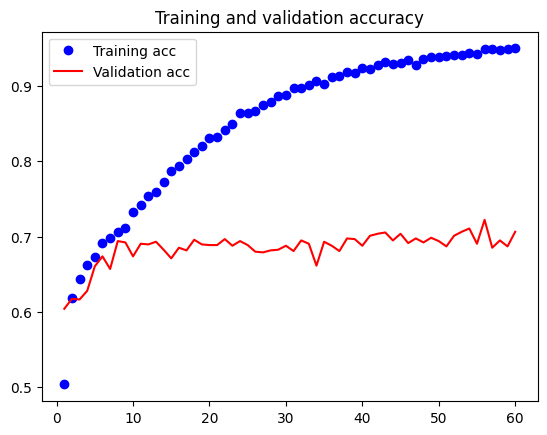

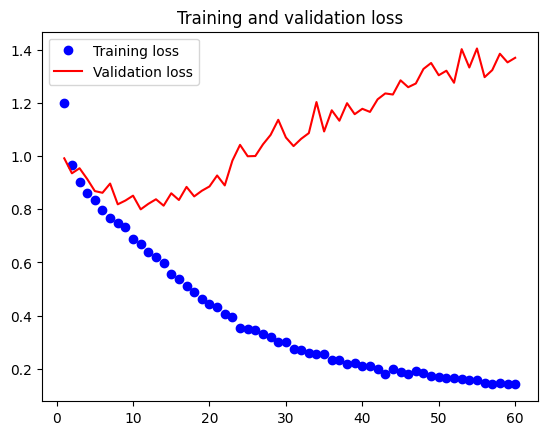

In [15]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

##### Observations

From the training and validation accuracies and loss plots the first thing you can see is that the model appears to perform better on the training data than the validation data. Also as we have a high validation loss and a low training loss, seen in the plots as the gap between the two increasing, this would suggest that overfitting has occurred, which may suggest this model would benefit from a simpler model.

## Q1a(iii) (8 marks)

Evaluate the trained model with the test data, and output the classification accuracy.

Plot and comment on the intermediate feature maps after each convolution layer for at least one sample test image.

Save your model as `tma02_q1a_model_0.keras`. Note that the suffix (.keras) of the file name is different from what is originally specified in the VLE (.h5), as the .h5 format is now deprecated. So please save your model in .keras instead. The same applies to the other models in Question 1b.

### Add your solution below. Add additional cells as needed.

##### Evaluating the trained model_0 with the test data and output the classification accuracy


In [10]:
model_0.evaluate(test_data)

67/67 [==============================] - 3s 26ms/step - loss: 1.2907 - accuracy: 0.7054


[1.2906897068023682, 0.7054263353347778]

##### Sample test images

In [11]:
# Sample test images
test_batch, test_batch_labels = test_data.as_numpy_iterator().next()
test_batch.shape

(64, 150, 150, 3)

##### Listing the layers in model_0 (index of convolution layers: 0, 2, 4, 5, 6, 7)

In [13]:
# List layers in the model, and pay attention to the index of the covolution layers:  0, 2, 4, 5, 6, 7.

list(enumerate(model_0.layers))

[(0, <keras.src.layers.convolutional.conv2d.Conv2D at 0x7fd77413b130>),
 (1, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D at 0x7fd77413b730>),
 (2, <keras.src.layers.convolutional.conv2d.Conv2D at 0x7fd774106400>),
 (3, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D at 0x7fd7741220d0>),
 (4, <keras.src.layers.convolutional.conv2d.Conv2D at 0x7fd7741222b0>),
 (5, <keras.src.layers.convolutional.conv2d.Conv2D at 0x7fd77412f100>),
 (6, <keras.src.layers.convolutional.conv2d.Conv2D at 0x7fd77412fe50>),
 (7, <keras.src.layers.convolutional.conv2d.Conv2D at 0x7fd7740b63d0>),
 (8, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D at 0x7fd77413b970>),
 (9, <keras.src.layers.regularization.dropout.Dropout at 0x7fd7740c0910>),
 (10, <keras.src.layers.reshaping.flatten.Flatten at 0x7fd77413ba90>),
 (11, <keras.src.layers.core.dense.Dense at 0x7fd7740c6160>),
 (12, <keras.src.layers.core.dense.Dense at 0x7fd7740c6f70>)]

##### Converting the layer indices

In [14]:
conv_layer_indices = [i for i, l in enumerate(model_0.layers) if 'conv' in l.name]
conv_layer_indices

[0, 2, 4, 5, 6, 7]

##### Generating the feature maps for each convolution layer

Original image


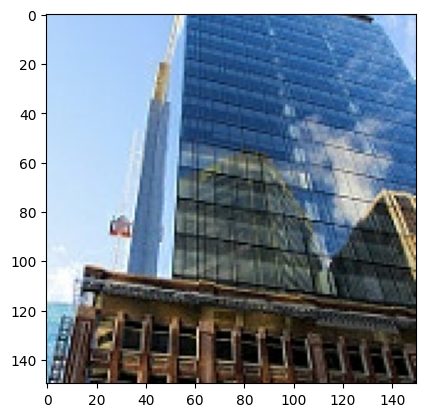

Feature maps generated from layer 0


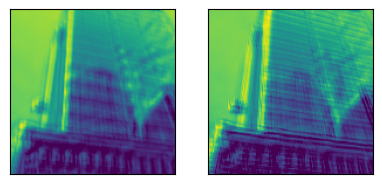

Feature maps generated from layer 2


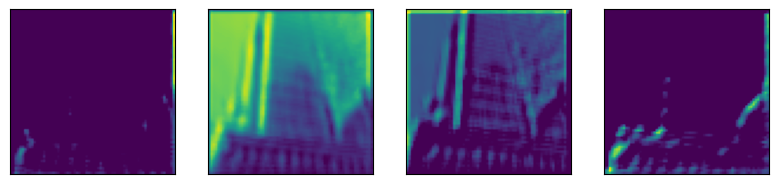

Feature maps generated from layer 4


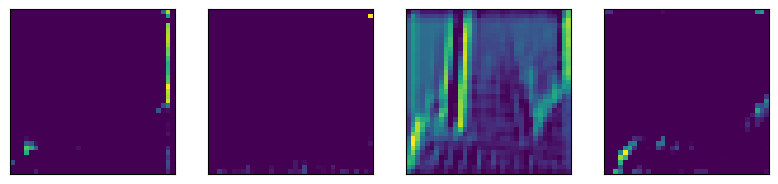

Feature maps generated from layer 5


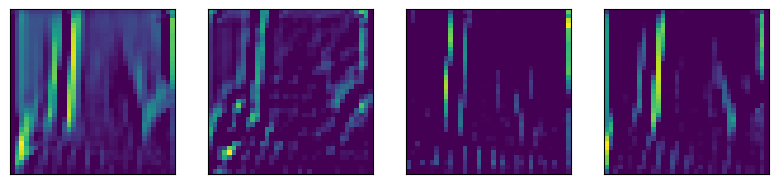

Feature maps generated from layer 6


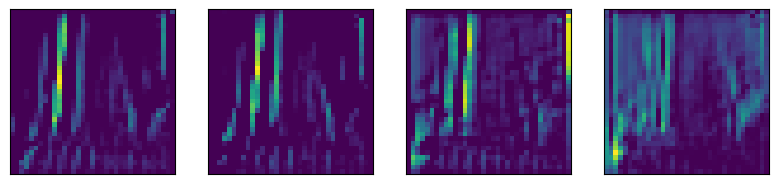

Feature maps generated from layer 7


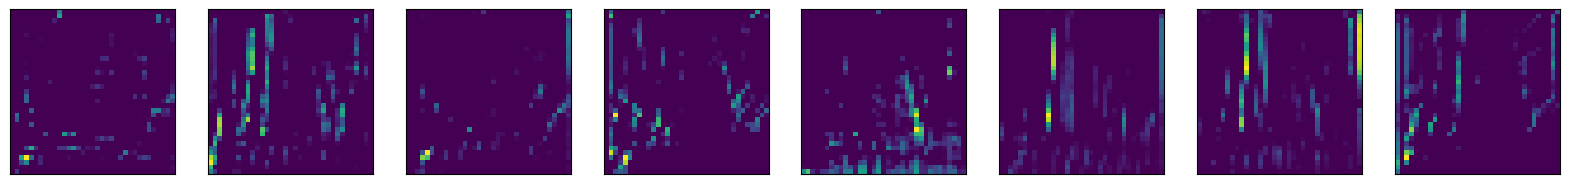

In [20]:
pi = 48 # set the sample image index

# plot the first sample image
print(f'Original image')
plt.figure()
plt.imshow(test_batch[pi])
plt.show()

for li in conv_layer_indices: # layer index
    print(f'Feature maps generated from layer {li}')
    intermediate_layer_model_0 = keras.Model(inputs=model_0.input,
                                       outputs=model_0.layers[li].output)
    
    intermediate_output = intermediate_layer_model_0(test_batch)

    plt.figure(figsize=(20, 5))

    for i in range(16):
        if i < intermediate_output.shape[-1]:
            plt.subplot(2, 8, i+1)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(intermediate_output[pi,:,:,i])
    plt.show()

##### Commenting on the intermediate feature maps

From the feature maps generated we can see that the feature maps generated close to the input of the model give a lot more detail than those closer to the output of the model. As we go from layer to layer the feature maps show less detail than those of the previous layer.

---
# Question 1b (25 marks)

Create, train and evaluate three extra CNN models by extending the `model_0` from Question 1a. 

For each model, you are required to do the following:

+ print the summary of model structure
+ train the model over 60 epochs
+ plot the training and validation accuracies and losses
+ evaluate the trained model with the test data 
+ explain what you observe. 

## Q1b(i) (5 marks)

### `model_1`

Take the structure of `model_0`, and quadruple the number of filters in each convolutional layer (so the first layer has 8 filters and the last convolutional layer has 32 filters).

Leave the dense layers as they are.

Save your model as `tma02_q1b_model_1.keras`. 

### Add your solution below. Add additional cells as needed.

##### Creating model_1

This is based on the same structure as model_0 but we have quadrupled the number of filters in each convolutional layer.

In [9]:
model_1 = Sequential([
    Conv2D(filters=8, kernel_size=10, input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=16, kernel_size=6, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=4, padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])
model_1.summary() #displays model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 141, 141, 8)       2408      
                                                                 
 max_pooling2d (MaxPooling2  (None, 70, 70, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 35, 35, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 35, 16)        6416      
                                                                 
 conv2d_3 (Conv2D)           (None, 35, 35, 16)        4

##### Compiling model_1

In [10]:
model_1.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

##### Training model_1 over 60 epochs

In [12]:
history = model_1.fit(train_data,
    validation_data=validation_data,
    epochs=60,
    verbose = 0, # used to omit the training information                  
    )

2024-01-25 11:40:47.239928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


##### Saving model_1

In [15]:
# Save the model and the training history.
model_1.save('tma02_q1b_model_1.keras')
with open('tma02_q1b_model_1_history.json', 'w') as f:
    json.dump(history.history, f)

##### Reloading model_1

In [16]:
# reloading the model
model_1 = tf.keras.models.load_model('tma02_q1b_model_1.keras')

with open('tma02_q1b_model_1_history.json') as f:
    sample_history = json.load(f)

##### Plotting the training and validation accuracies and losses for model_1

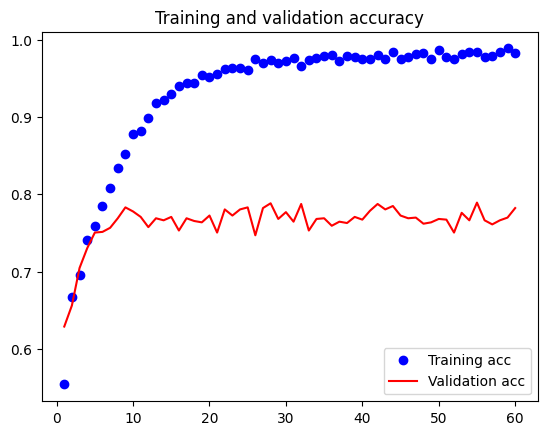

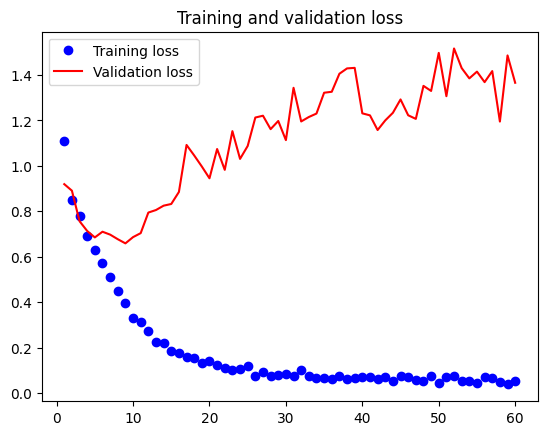

In [13]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

##### Evaluating the trained model_1 with the test data and output the classification accuracy


In [17]:
model_1.evaluate(test_data)

67/67 [==============================] - 2s 28ms/step - loss: 1.6156 - accuracy: 0.7689


[1.6155747175216675, 0.7688512802124023]

##### Observations

As seen in the evaluation results, model_1 has improved accuracy over model_0 from 71% (model_0) to 77% (model_1).

From the plots we can see that the training data plateaus from around 30 epochs onwards, coupled with the low training loss and high validation loss would suggest overfitting, but less so than that of model_0 as the gaps between the training plot and validation plots is less.

## Q1b(ii) (8 marks)

### `model_2`

For this question, refer to the `model_0` summary as detailed below.

Based on what you have learnt from **Notebook Activity 3 (residual connections)**, modify `model_0` as follows:

+ add a residual link from the output of the layer **marked (a)** to the output of the layer **marked (b)** (i.e. skipping the convolution layers with output shapes (35, 35, 4))

+ and another residual link from the output of the layer **marked (c)** to the output of the layer **marked (d)** (i.e., skipping the final convolution layer) 

+ Save your model as `tma02_q1b_model_2.keras`

| Layer type | Output Shape | Param # | Notes |
|------------|--------------|---------|-------|
| Conv2D | (None, 141, 141, 2) | 602 |   |
| MaxPooling2D | (None, 70, 70, 2) | 0 |   |
| Conv2D | (None, 70, 70, 4) | 292 |   |
| MaxPooling2D | (None, 35, 35, 4) | 0 | **(a)** |
| Conv2D | (None, 35, 35, 4) | 404 |   |
| Conv2D | (None, 35, 35, 4) | 260 |   |
| Conv2D | (None, 35, 35, 4) | 148 | **(b)** |
| Conv2D | (None, 35, 35, 8) | 296 | **(c)** |
| Conv2D | (None, 35, 35, 8) | 584 | **(d)** |
| MaxPooling2D | (None, 17, 17, 8) | 0 |   |
| Dropout | (None, 17, 17, 8) | 0 |   |
| Flatten | (None, 2312) | 0 |   |
| Dense | (None, 128) | 296064 |   |
| Dense | (None, 6) | 774 |   

### Add your solution below. Add additional cells as needed.

##### Building a base model

First we start by building a base model based on model_0

In [9]:
baseline_model = Sequential([
    Conv2D(filters=2, kernel_size=10, input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=4, kernel_size=6, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=4, kernel_size=5, padding='same', activation='relu'),
    Conv2D(filters=4, kernel_size=4, padding='same', activation='relu'),
    Conv2D(filters=4, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])
baseline_model.summary() #displays model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 141, 141, 2)       602       
                                                                 
 max_pooling2d (MaxPooling2  (None, 70, 70, 2)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 4)         292       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 35, 35, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 35, 4)         404       
                                                                 
 conv2d_3 (Conv2D)           (None, 35, 35, 4)         2

##### Implementing the residual connections

This is done by building a 'functional' style model

In [31]:
# The convolution and MaxPool layers are labelled by A-I

def build_res_model(include_skip=True):
    
    model_input = Input(shape=(150, 150, 3))
    
    a = Conv2D(filters=2, kernel_size=10, activation='relu')(model_input)
    b = MaxPooling2D(pool_size=2)(a)
    
    c = Conv2D(filters=4, kernel_size=6, padding='same', activation='relu')(b)
    d = MaxPooling2D(pool_size=2)(c)
    e = Conv2D(filters=4, kernel_size=5, padding='same', activation='relu')(d)
    f = Conv2D(filters=4, kernel_size=4, padding='same', activation='relu')(e)
    
    if include_skip:
        df = Add()([d,f]) #this selection allows the model to be built (see below)
                          #but not sure why as this doesn't follow the example, could you possibly explain
    else:
        df = f
        
    g = Conv2D(filters=4, kernel_size=3, padding='same', activation='relu')(df)
    h = Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(g)
    i = MaxPooling2D(pool_size=2)(h)
    
    if include_skip:
        hi = Add()([h,h]) #this selection allows the model to be built (see below)
                          #but not sure why as this doesn't follow the example, could you possibly explain
        
    else:
        hi = i
        
    
    
    x = Dropout(rate=0.5)(hi)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(6, activation='softmax')(x)
    
    return tf.keras.Model(inputs=model_input, outputs=x, name='res_model')

##### Building the model with residual links

By setting include_skip=True we get a model with residual links.

In [32]:
model_2 = build_res_model(include_skip=True)
model_2.summary()

Model: "res_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 141, 141, 2)          602       ['input_13[0][0]']            
                                                                                                  
 max_pooling2d_30 (MaxPooli  (None, 70, 70, 2)            0         ['conv2d_70[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_71 (Conv2D)          (None, 70, 70, 4)            292       ['max_pooling2d_30[0][

##### Compiling model_2

In [33]:
model_2.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

##### Training model_2

In [34]:
history = model_2.fit(train_data,
    validation_data=validation_data,
    epochs=60,
    verbose = 0, # used to omit the training information                  
    )

2024-01-29 19:29:19.493764: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inres_model/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


##### Saving model_2

In [35]:
# Save the model and the training history.
model_2.save('tma02_q1b_model_2.keras')
with open('tma02_q1b_model_2_history.json', 'w') as f:
    json.dump(history.history, f)

###### Reloading model_2 (if required)


In [36]:
# reloading the model
model_2 = tf.keras.models.load_model('tma02_q1b_model_2.keras')

with open('tma02_q1b_model_2_history.json') as f:
    sample_history = json.load(f)

##### Plotting the training and validation accuracies and losses for model_2

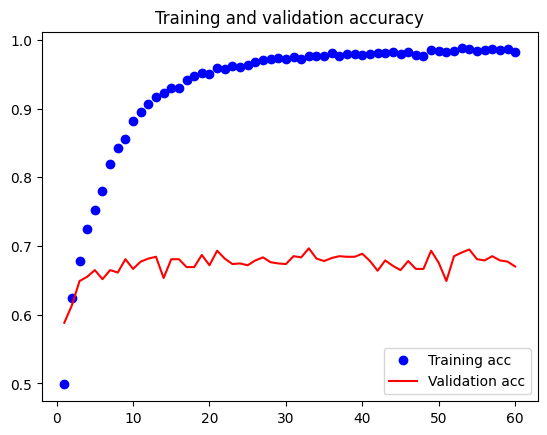

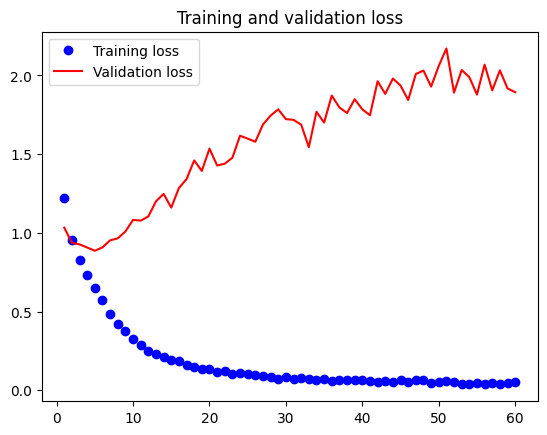

In [37]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

##### Evaluating the trained model_2 with the test data and output the classification accuracy


In [38]:
model_2.evaluate(test_data)

67/67 [==============================] - 2s 30ms/step - loss: 2.0133 - accuracy: 0.6711


[2.0133280754089355, 0.6711298823356628]

##### Observations

As seen in the evaluation results, model_2 has a decreased accuracy when compared to model_0 (71%) and model_1 (77%)

From the plots we can see that the training data plateaus from around 30 epochs onwards so overtraining may occur. Also the low training loss and high validation loss would suggest overfitting.

## Q1b(iii) (8 marks)

### `model_3`

Based on what you have learnt from the **Notebook Activity 4 (data augmentation)** from Block 2 create `model_3` and train the model as follows:

+ Generate **augemented training data** using **two** data augmentation methods (e.g. normalisation, horizontal translation, or rotation)

+ Create `model_3` using the same structure as `model_1` above 

+ Train `model_3` with the augmented training data 

+ Save your model as `tma02_q1b_model_3.keras`. 

### Add your solution below. Add additional cells as needed.

##### Setting up normalisation

In [14]:
# Data normalisation
norm_layer = Normalization(input_shape= (150, 150, 3))
norm_layer.adapt(train_data.map(lambda x, y: x))

##### Setting up data augmentation

Here we will use a random rotation of 0.2 to create additional training data

In [15]:
data_augmentation = tf.keras.Sequential([

  layers.RandomRotation(0.2)
])

# Augmented all the images in our train_data
aug_train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
aug_train_data = aug_train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

##### Creating model_3

Here we create model_3, which is based on model_1, including the normalisation layer

In [16]:
model_3 = Sequential([
    
    norm_layer, # Normalise the data as the first step in processing
    
    Conv2D(filters=8, kernel_size=10, input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=16, kernel_size=6, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=4, padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])
model_3.summary() #displays model summary

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 150, 150, 3)       7         
 on)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 141, 141, 8)       2408      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 70, 70, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 70, 70, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 35, 35, 16)        0         
 g2D)                                                            
                                                      

##### Compiling model_3

In [17]:
model_3.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

##### Training model_3

Here we will train model_3 for 60 epochs using the augmented training data

In [18]:
history = model_3.fit(aug_train_data,
    validation_data=validation_data,
    epochs=60,
    verbose = 0, # used to omit the training information                  
    )

2024-01-25 15:02:10.059334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


##### Saving model_3

In [20]:
# Save the model and the training history.
model_3.save('tma02_q1b_model_3.keras')
with open('tma02_q1b_model_3_history.json', 'w') as f:
    json.dump(history.history, f)

##### Reloading model_3

In [21]:
# reloading the model
model_3 = tf.keras.models.load_model('tma02_q1b_model_3.keras')

with open('tma02_q1b_model_3_history.json') as f:
    sample_history = json.load(f)

##### Creating training and validation loss and accuracy plots for model_3

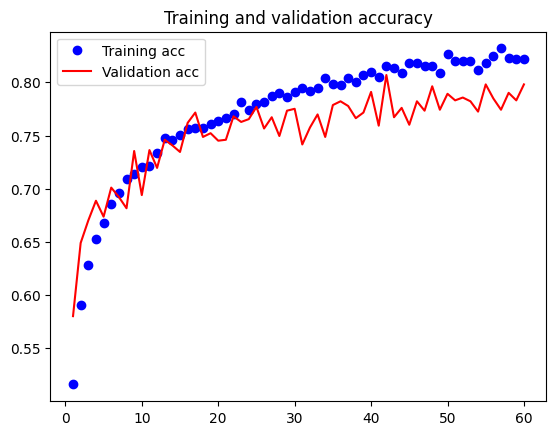

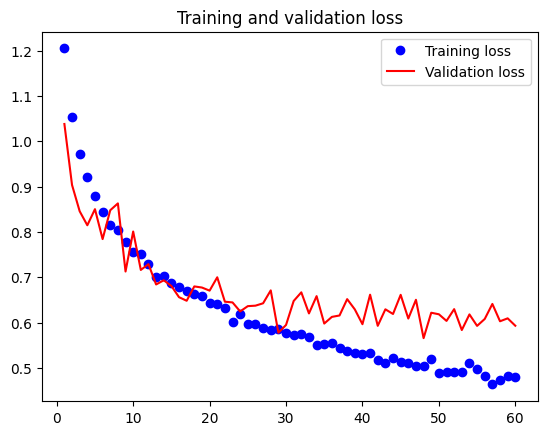

In [22]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

##### Evaluating the trained model_1 with the test data and output the classification accuracy

In [23]:
model_3.evaluate(test_data)

67/67 [==============================] - 2s 29ms/step - loss: 0.6143 - accuracy: 0.7945


[0.6143154501914978, 0.7944561839103699]

##### Observations

From the evaluation results we can see that the accuracy is now at 79%, which is the highest yet. 

Looking at the plots we can see that there is no plateauing of the training data suggesting more training could be done. In these plots the validation data plots have the smallest gap so far to the training data plot, this still may suggest some overfitting, but as the plots haven't plateaued yet, then we cannot say for sure.

## Q1b(iv) (4 marks)

### Comparison

Compare the performance of the four models (`model_0` from Q1a, and the three models in Q1b).

Decribe the performance of the four models from the evalautions of the test data.

## Write your answer below. Add additional markdown cells as needed.

From the four models (model_0, model_1, model_2, model_3) it can clearly be seen that model_3 is the best performing model
as it has an accuracy of 79% and as the plots suggest further training of this model could be carried out as the training plot has not plateaued and also to see if any overfitting has occured.

The other three models all display characteristics of overfitting with model_1 being the best of the rest, with an accuracy of 77% and also the smallest difference between the training and validation plots.

Model_2 is the worst performing model in terms of accuracy and appears that by using residual links the performance of the model is reduced.
Increasing the number of filters (model_1) shows an improvement in the performance of the model but the best performing model is when normalisation and data augmentation is used.
